<a href="https://colab.research.google.com/github/Mattlee10/zone2/blob/main/25_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 수집

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_health_export(xml_path, record_types=None):
    """
    Apple Health Export XML에서 원하는 Record Type만 추출
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []

    for rec in root.findall('Record'):
        rtype = rec.get('type')
        if record_types and rtype not in record_types:
            continue
        val = rec.get('value')
        if val is None:
            continue
        records.append({
            'type': rtype,
            'value': float(val),
            'unit': rec.get('unit'),
            'start': pd.to_datetime(rec.get('startDate')),
            'end': pd.to_datetime(rec.get('endDate'))
        })

    return pd.DataFrame(records)

# XML 경로 설정 (Google Drive에서 마운트한 경로 또는 Colab 업로드 경로)
xml_path = '/content/drive/MyDrive/Export_ds.xml'

# 필요 Record Type 정의
record_types = [
    'HKQuantityTypeIdentifierHeartRate',
    'HKQuantityTypeIdentifierRestingHeartRate',
    'HKQuantityTypeIdentifierHeartRateVariabilitySDNN'
]

# 파싱 실행
df = parse_health_export(xml_path, record_types=record_types)

# 결과 미리보기
print(df.head())

                                type    value       unit  \
0  HKQuantityTypeIdentifierHeartRate  66.0000  count/min   
1  HKQuantityTypeIdentifierHeartRate  77.0000  count/min   
2  HKQuantityTypeIdentifierHeartRate  71.9442  count/min   
3  HKQuantityTypeIdentifierHeartRate  70.0000  count/min   
4  HKQuantityTypeIdentifierHeartRate  75.0000  count/min   

                      start                       end  
0 2021-06-24 22:43:39+09:00 2021-06-24 22:43:39+09:00  
1 2021-06-24 22:44:53+09:00 2021-06-24 22:44:53+09:00  
2 2021-06-24 22:49:47+09:00 2021-06-24 22:49:47+09:00  
3 2021-06-24 22:50:54+09:00 2021-06-24 22:50:54+09:00  
4 2021-06-24 23:00:35+09:00 2021-06-24 23:00:35+09:00  


# 데이터 전처리

In [2]:
# 사용자 정보
AGE = 31  # 사용자 나이
MAX_HR = 220 - AGE

# 안정 심박수 평균 계산 (RestingHeartRate 평균값)
rhr_df = df[df['type'] == 'HKQuantityTypeIdentifierRestingHeartRate']
RHR = rhr_df['value'].mean()
print(f"안정심박수 평균: {RHR:.1f} bpm")

# NEAT zone 설정 (예: 강도 25~50%)
NEAT_MIN = RHR + (MAX_HR - RHR) * 0.25
NEAT_MAX = RHR + (MAX_HR - RHR) * 0.50
print(f"NEAT 구간: {NEAT_MIN:.1f} ~ {NEAT_MAX:.1f} bpm")

안정심박수 평균: 62.7 bpm
NEAT 구간: 94.3 ~ 125.9 bpm


In [3]:
# 심박수 데이터 필터링
hr_df = df[df['type'] == 'HKQuantityTypeIdentifierHeartRate'].copy()

# NEAT zone 여부 컬럼 생성
hr_df['in_neat_zone'] = hr_df['value'].between(NEAT_MIN, NEAT_MAX)

In [4]:
# 날짜 컬럼 생성
hr_df['date'] = hr_df['start'].dt.date

# 원하는 날짜 범위 설정
start_date = pd.to_datetime("2025-05-19").date()
end_date = pd.to_datetime("2025-05-23").date()

# 해당 범위로 필터링
filtered_df = hr_df[(hr_df['date'] >= start_date) & (hr_df['date'] <= end_date)]

In [5]:
daily_summary = filtered_df.groupby('date')['in_neat_zone'].mean().reset_index()
daily_summary.rename(columns={'in_neat_zone': 'neat_ratio'}, inplace=True)
daily_summary['neat_percent'] = daily_summary['neat_ratio'] * 100

In [6]:
def categorize_neat(percent):
    if percent < 20:
        return "0–20%"
    elif percent < 40:
        return "20–40%"
    elif percent < 60:
        return "40–60%"
    else:
        return "60% 이상"

daily_summary['neat_zone_level'] = daily_summary['neat_percent'].apply(categorize_neat)

In [7]:
print(daily_summary[['date', 'neat_percent', 'neat_zone_level']])

         date  neat_percent neat_zone_level
0  2025-05-19     67.739464          60% 이상
1  2025-05-20     52.986811          40–60%
2  2025-05-21     38.024165          20–40%
3  2025-05-22     60.025873          60% 이상
4  2025-05-23     51.797235          40–60%


<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-8-31e93be0e569>:24: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input

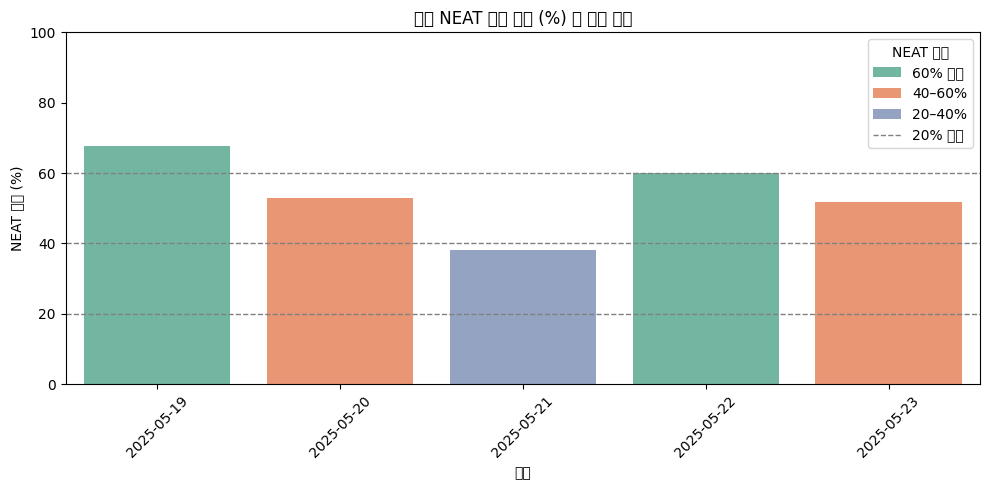

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(
    x='date',
    y='neat_percent',
    hue='neat_zone_level',
    data=daily_summary,
    palette='Set2'
)

# 기준선 (선택)
plt.axhline(20, color='gray', linestyle='--', linewidth=1, label='20% 기준')
plt.axhline(40, color='gray', linestyle='--', linewidth=1)
plt.axhline(60, color='gray', linestyle='--', linewidth=1)

plt.title('일별 NEAT 체류 비율 (%) 및 구간 분류')
plt.ylabel('NEAT 비율 (%)')
plt.xlabel('날짜')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend(title='NEAT 구간')
plt.tight_layout()
plt.show()

In [9]:
def classify_time(hour):
    if 6 <= hour < 10:
        return '아침 (6~10시)'
    elif 10 <= hour < 14:
        return '오전 (10~14시)'
    elif 14 <= hour < 18:
        return '오후 (14~18시)'
    elif 18 <= hour < 22:
        return '저녁 (18~22시)'
    else:
        return '야간/새벽'

# 기존 필터링된 데이터 기준 (filtered_df)
filtered_df['hour'] = filtered_df['start'].dt.hour
filtered_df['time_block'] = filtered_df['hour'].apply(classify_time)

<ipython-input-9-e5dd8eb2afe9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hour'] = filtered_df['start'].dt.hour
<ipython-input-9-e5dd8eb2afe9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_block'] = filtered_df['hour'].apply(classify_time)


In [10]:
timeblock_summary = (
    filtered_df.groupby(['date', 'time_block'])['in_neat_zone']
    .mean()
    .reset_index()
)

timeblock_summary['neat_percent'] = timeblock_summary['in_neat_zone'] * 100

In [11]:
pivot_table = timeblock_summary.pivot(index='time_block', columns='date', values='neat_percent')
pivot_table = pivot_table.reindex(['아침 (6~10시)', '오전 (10~14시)', '오후 (14~18시)', '저녁 (18~22시)', '야간/새벽'])

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52840 (\N{HANGUL SYLLABLE CIM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/loca

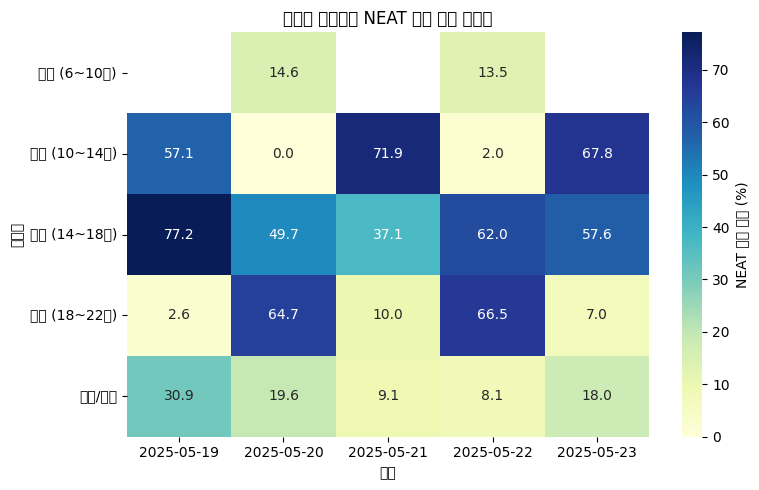

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'NEAT 체류 비율 (%)'})
plt.title("날짜별 시간대별 NEAT 활동 비율 히트맵")
plt.xlabel("날짜")
plt.ylabel("시간대")
plt.tight_layout()
plt.show()